# Building a Predictive Maintenance Solution Using AWS AutoML and No-code Tools 

# Part 1. Creation, evaluation, and deployment of the model

It is the first notebook of the two ones accompanying our blog-article with the above title. 

Here we show how it is possible to create and deploy a state-of-the-art ML-model for prediction of the Remaining Useful Life (RUL) without delving  into Machine Learning, Data Science, DevOps knowledge. The maior tool of this workflow is the <b> AWS SageMaker Autopilot </b> service.

In [ ]:
# Import all the necessary modules
import pandas as pd
import sagemaker
import boto3
import time
from datetime import datetime
from sagemaker import AutoML
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Specify the path to the training data

In [ ]:
#  Specify the s3-path to the training data:
DATA_LOCATION_S3_BUCKET = 's3://anomaly-detection-bucket-test/datasets/turbofan_nasa_data/turbofan_sensors-orig_train.csv' 

In [ ]:
# Data frame that contains only the features we are going to use.
train_data = pd.read_csv(DATA_LOCATION_S3_BUCKET)
train_data.head()

,time,rul,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,150,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,150,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,150,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,150,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,150,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# Running an AutoPilot Experiment

The goal of this stage is to obtain an optimized trained model using our training dataset. All the work is performed under the hood of <b>AWS SageMaker Autopilot</b>: creation of many various models, their training, optimization of hyperparameters, and the choice of the best model. All these huge piece of work is performed <b> without any intervention of the user</b>.

In [ ]:
# Here we define some crucial parameters for running an AutoPilot experiment.

AUTO_ML_JOB_NAME = 'test-notebook-experiment-sm05'  # name of the experiment - should be unique
S3_OUTPUT_PATH = 's3://anomaly-detection-bucket-test/datasets/turbofan_nasa_data/'  # directory, where the artifacts will be stored in S3
ENDPOINT_NAME = 'test-notebook-autopilot-experiment-endpoint' # name of real time endpoint for serving the model
MAX_NUMBER_OF_CANDIDATES = 10  # number of candidates for hyperparameter tuning, usully has to be set to bigger number 

EXECUTION_ROLE = sagemaker.get_execution_role() 
SESSION = sagemaker.Session()

In [ ]:
# Just a helper function that helps to monitor the status of the experiment

def monitor_the_job_status(auto_ml_job_name, interval_update=20):
    """
    auto_ml_job_name: the job we want to monitor
    interval_update: in seconds, how frequent we want to make requests
    """
    client = boto3.client('sagemaker')
    response = client.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_status = 'InProgress'
    while job_status == 'InProgress':
        response = client.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = response['AutoMLJobStatus']
        secondary_job_status = response['AutoMLJobSecondaryStatus']
        time_now = datetime.now().strftime('%H:%M:%S')
        print(f"Job status: {job_status}; Secondary job status: {secondary_job_status} -- {time_now}")
        time.sleep(interval_update)
    final_status = response['AutoMLJobStatus']
    final_secondary_job_status = response['AutoMLJobSecondaryStatus']
    time_now = datetime.now().strftime('%H:%M:%S')
    print(f"Final Job status: {final_status}; Final Secondary job status: {final_secondary_job_status} -- {time_now}")

In [ ]:
# We use sagemaker Python API to create AutoPilot job. First, we need to fit the model. 
# We indicte the number of candidates (basically the combination of models and relevant hyperparameters), so we can select the best model for further deployment.

from sagemaker import AutoML

automl = AutoML(role=EXECUTION_ROLE, 
                target_attribute_name='rul',  # the target variable we want to predict
                base_job_name=AUTO_ML_JOB_NAME,
                sagemaker_session=SESSION,
                max_candidates=MAX_NUMBER_OF_CANDIDATES,
                problem_type='Regression',
                job_objective={'MetricName': 'MSE'} # here we have to indicate the problem type, otherwise AutoPilot confuses the problem 
                                                    # with multiclass classification problem
                )                          

automl.fit(inputs=DATA_LOCATION_S3_BUCKET, job_name=AUTO_ML_JOB_NAME, wait=True, logs=True) # wait and logs is True in order to get the progress bar of dots that we
                                                                                            # can observe below

..................................................................................................................................................................

In [ ]:
# in case, we want more verbose log output, we set wait and logs to False, and just call this function
monitor_the_job_status(auto_ml_job_name=AUTO_ML_JOB_NAME, interval_update=30)

Job status: InProgress; Secondary job status: MergingAutoMLTaskReports -- 21:33:16
Job status: InProgress; Secondary job status: MergingAutoMLTaskReports -- 21:33:46
Job status: InProgress; Secondary job status: MergingAutoMLTaskReports -- 21:34:16
Job status: InProgress; Secondary job status: MergingAutoMLTaskReports -- 21:34:46
Job status: Completed; Secondary job status: Completed -- 21:35:16
Final Job status: Completed; Final Secondary job status: Completed -- 21:35:46


One of the artifacts that comes out of AutoPilot experiment is the set of models. Model is pretrained algorithm, with adjusted hyperparameters. We can select the best candidate that gives us the optimum metric (that we selected before). Best model will be used later for batch prediction inference mode.

Here, for the sake of simplicity, we do not choose a model, but we simply use the best one having a minimal RMSE value.

# Evaluation of the model

Here we obtain several basic metrics describing the quality of the model. 

We also get a reference to the PDF-file with the results of the feature importance analysis.

In [ ]:
# Get the best model
automl = AutoML.attach(auto_ml_job_name=AUTO_ML_JOB_NAME)
best_candidate = automl.best_candidate(job_name=AUTO_ML_JOB_NAME) # select the best candidate for deployment

In [ ]:
# We can check the performance of the model by exploring best candidate properties
best_candidate['CandidateProperties']['CandidateMetrics'] 

[{'MetricName': 'MSE', 'Value': 466.4531555175781, 'Set': 'Validation'},
 {'MetricName': 'MAE', 'Value': 16.749845504760742, 'Set': 'Validation'},
 {'MetricName': 'R2', 'Value': 0.8132867217063904, 'Set': 'Validation'},
 {'MetricName': 'RMSE', 'Value': 21.596208572387695, 'Set': 'Validation'}]

In [ ]:
# We may look for pieces of other relevant information on evaluation of the model,
# for example, the path to the PDF-file with a feature importance report
# (see the "Explainability" section in the output)
best_candidate['CandidateProperties']['CandidateArtifactLocations']

{'Explainability': 's3://sagemaker-us-east-1-283824160429/test-notebook-experiment-sm05/documentation/explainability/output',
 'ModelInsights': 's3://sagemaker-us-east-1-283824160429/test-notebook-experiment-sm05/documentation/model_monitor/output'}

# Deployment
The ultimate goal of this stage is to create  an endpoint for our trained model.
Then, we may use this endpoint for real-time online predictions.

In [ ]:
# Deployment - create endpoint. Here we specify the real time enpoint name. With sagemaker API we have to make deployment as the separate step. 
# Once it is deployed, endpoint is ready to use.

automl.deploy(initial_instance_count=1, # how many machines are required for serving
              instance_type='ml.m5.2xlarge', # machine type
              serializer=None, # default to predictor class - in out case to whatever best candidate is
              deserializer=None, 
              candidate=None,  # if None, best candidate is used for deployment
              sagemaker_session=SESSION,
              endpoint_name=ENDPOINT_NAME, 
              wait=True) # just for verbosity, in order to see the progress bar below (deployment status)

---------------!

# Testing our endpoint

In our experiments we used following engine id's for test purposes: 7, 10, 23, 24, 32, 40, 43, 77, 88, 89. They were obtained by a random split. These 10 engines have not been used to train the model.

Here, to test the endpoint, we generate predictions of RUL for engines from the test dataset using our newly created endpoint. 

We also plot the predicted RUL-values against the true ones. It is a graphical tool for additional evaluation of the model, a kind of a "sanity check".

In [ ]:
predictor = sagemaker.predictor.Predictor(endpoint_name=ENDPOINT_NAME,
                                          sagemaker_session=sagemaker.Session(),
                                          serializer=sagemaker.serializers.CSVSerializer(),
                                          deserializer=sagemaker.deserializers.CSVDeserializer())

In [ ]:
DATA_FOR_TEST = "s3://anomaly-detection-bucket-test/datasets/turbofan_nasa_data/turbofan_sensors-orig_all_test.csv"

In [ ]:
test_data = pd.read_csv(DATA_FOR_TEST)
test_data.head()

,engine_id,time,rul,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,7,1,150,642.38,1589.49,1395.48,554.76,2387.97,9071.27,47.24,522.19,2387.99,8141.69,8.4081,390,38.97,23.4073
1,7,2,150,642.57,1583.11,1395.97,553.97,2388.00,9078.21,47.00,522.30,2388.02,8148.24,8.4216,391,38.85,23.5043
2,7,3,150,642.25,1589.44,1397.74,554.95,2387.95,9063.37,47.18,522.36,2387.98,8148.83,8.4258,392,39.07,23.4113
3,7,4,150,642.31,1585.59,1397.85,553.30,2388.06,9068.16,47.07,522.09,2388.06,8150.30,8.4175,392,39.12,23.4616
4,7,5,150,642.25,1587.23,1402.54,554.64,2388.04,9066.99,47.31,522.00,2388.01,8149.40,8.4099,391,38.94,23.4781


In [ ]:
#  Print the values of "engine_id" for the engines
#  included into the test dataset
test_data['engine_id'].unique()

array([ 7, 10, 23, 24, 32, 40, 43, 77, 88, 89])

In [ ]:
# Here we have helper functions 


def prepare_dataset_test(dataset_directory, engine_id=None):
    """
    test engine id are in [7, 10, 23, 24, 32, 40, 43, 77, 88, 89]
    """
    data_for_prediction = pd.read_csv(dataset_directory)
         
    if engine_id in [7, 10, 23, 24, 32, 40, 43, 77, 88, 89]:
        data_for_prediction = data_for_prediction[data_for_prediction['engine_id'] == engine_id]
        
        ruls = data_for_prediction['rul'].values
        data_for_prediction.drop(columns=['engine_id', 'rul'], inplace=True)
    
        return data_for_prediction, ruls
    else:
        print("Please specify the engine_id to be in the list [7, 10, 23, 24, 32, 40, 43, 77, 88, 89]")
        return


def produce_plot(engine_id, data_for_test, ruls, predicted_ruls):
    """
    The function just to produce plots
    """
    time = data_for_test['time'].values

    plt.rc('axes', titlesize=30)     # fontsize of the axes title
    plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
    plt.rc('legend', fontsize=30)   # fontsize of the legend
    
    figure(figsize=(24, 12))
    plt.plot(time, ruls, label = "True RUL")
    plt.plot(time, predicted_ruls, label = "Predicted RUL")
    plt.legend()
    plt.title(f"Engine id: {engine_id}")
    plt.xlabel('Time')
    plt.ylabel('Remaining Usefull Life')

    plt.show()

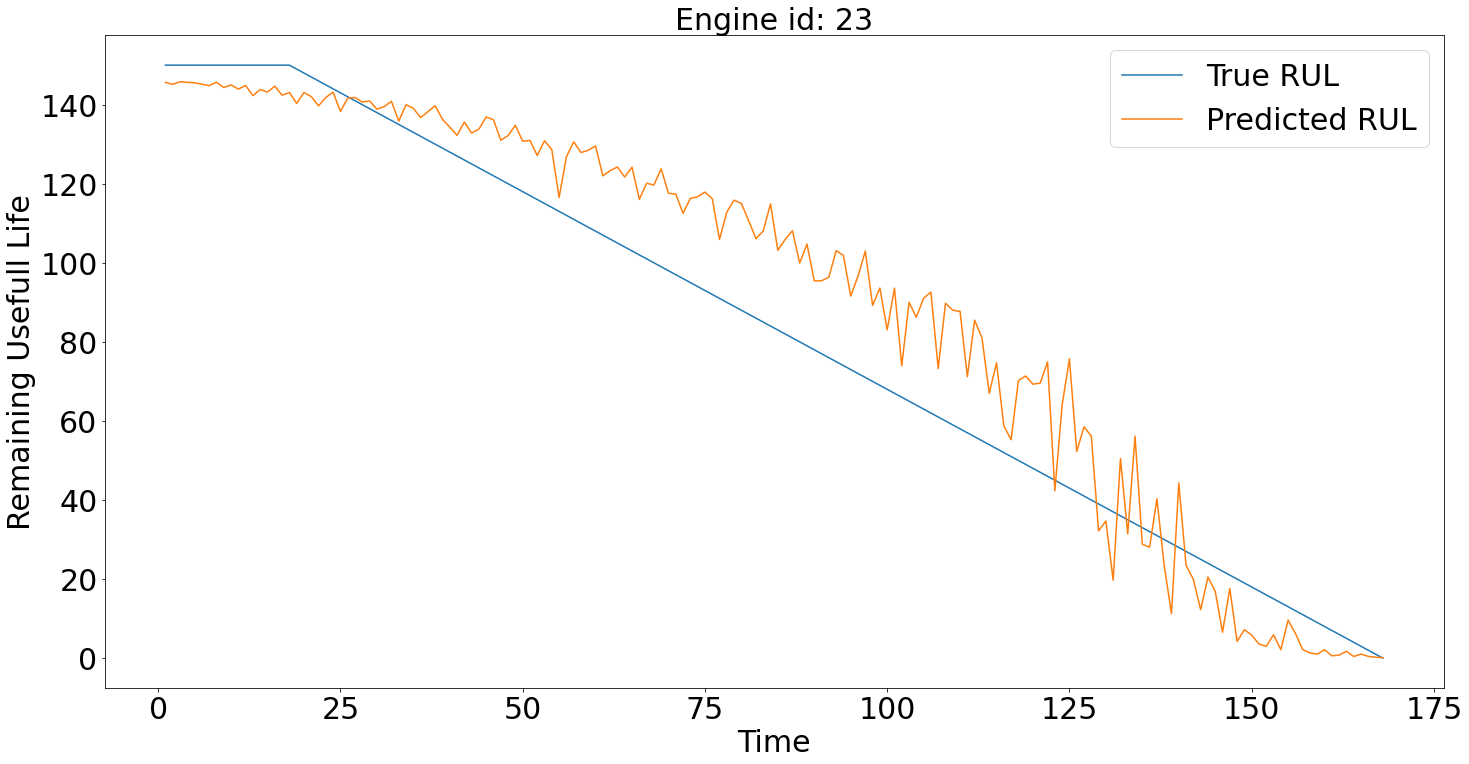

In [ ]:
# Here we visualize our data: 
# we plot the predictions of our model against the true RUL-values.
# This type of visualization allows us to perform additional evaluation
# of the model, a kind of a "sanity check".

ENGINE_ID = 23
data_for_prediction, ruls = prepare_dataset_test(dataset_directory=DATA_FOR_TEST, engine_id=ENGINE_ID)

if data_for_prediction is not None:

    # now we are making predictions and format them
    predictions = predictor.predict(data=data_for_prediction.values)
    predictions = list(itertools.chain.from_iterable(predictions))
    predictions = list(map(lambda x: float(x), predictions))

    # data_for_prediction['predicted_rul'] = predictions
    produce_plot(engine_id=ENGINE_ID, data_for_test=data_for_prediction, ruls=ruls, predicted_ruls=predictions)